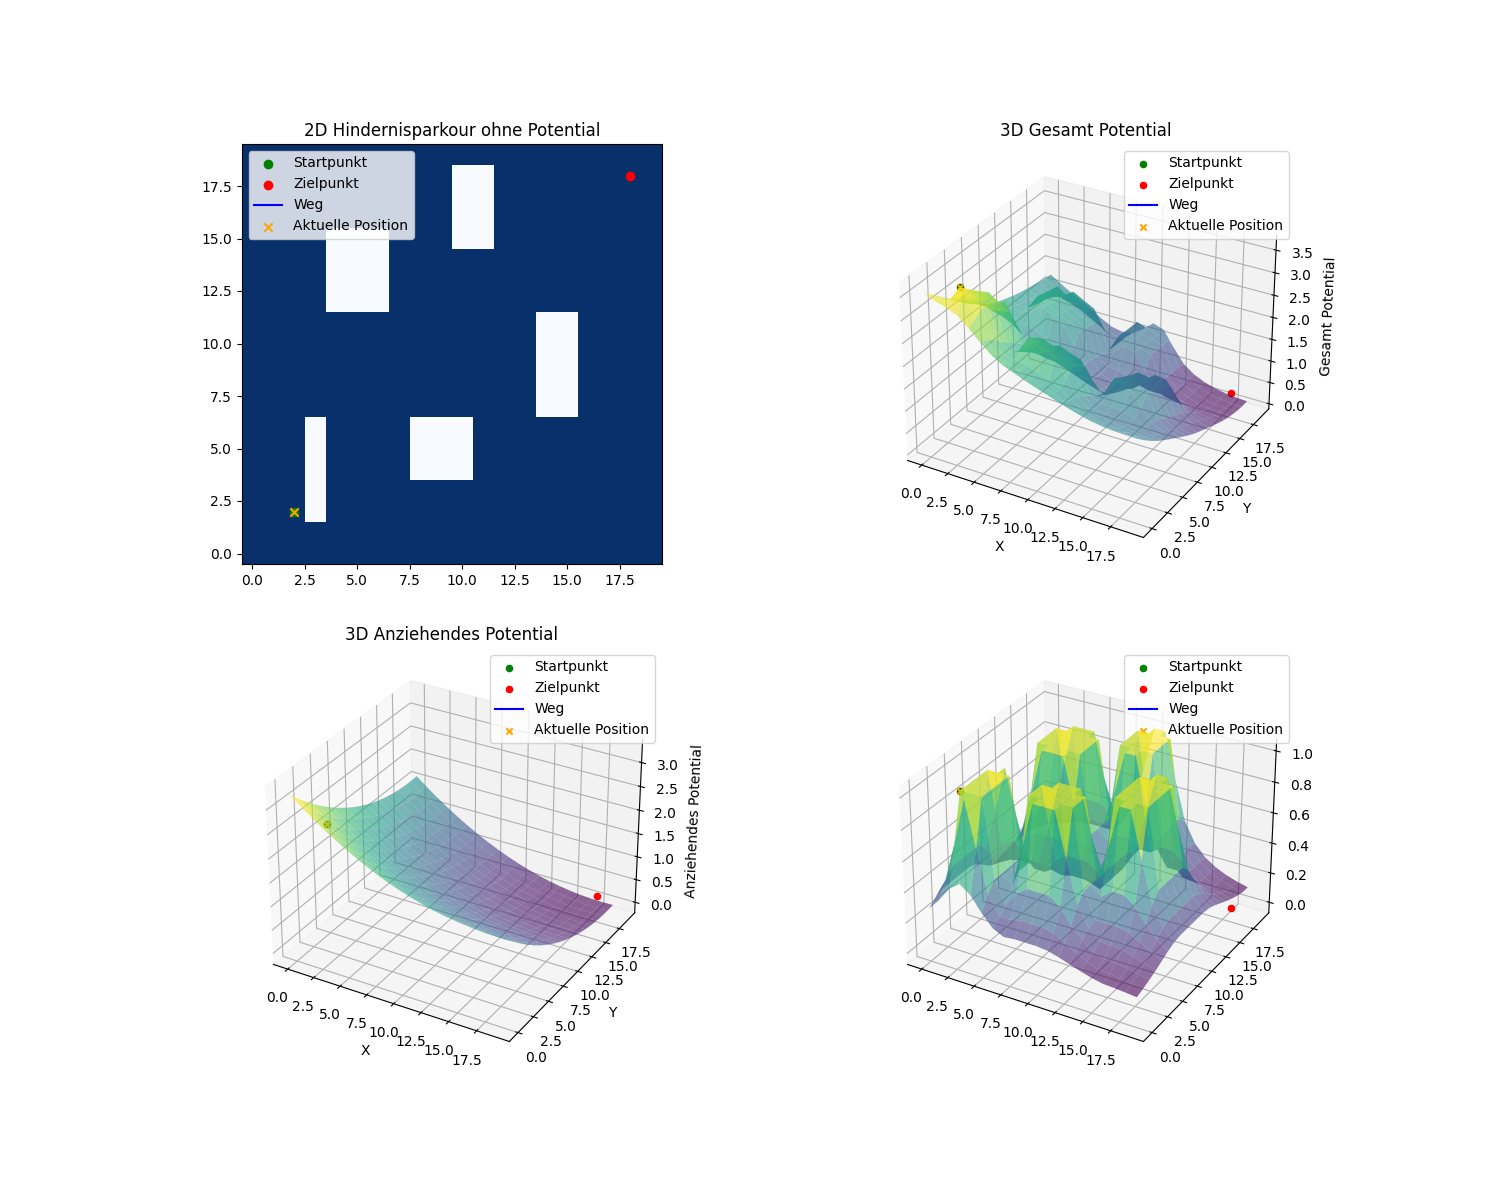

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%matplotlib widget
#import ipywidgets as widgets
#from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def add_obstacle(hindernisparkour, length, width, x, y):
    hindernisparkour[x:x+length, y:y+width] = False
    return hindernisparkour

def generate_complex_connected_obstacles(size=20, num_obstacles=5, max_length=5, max_width=3):
    hindernisparkour = np.ones((size, size), dtype=bool)

    # Hindernisse hinzufügen
    hindernisparkour = add_obstacle(hindernisparkour, 5, 1, 2, 3)
    hindernisparkour = add_obstacle(hindernisparkour, 3, 3, 4, 8)
    hindernisparkour = add_obstacle(hindernisparkour, 5, 2, 7, 14)
    hindernisparkour = add_obstacle(hindernisparkour, 4, 3, 12, 4)
    hindernisparkour = add_obstacle(hindernisparkour, 4, 2, 15, 10)

    return hindernisparkour

def create_potential_field(hindernisparkour, start, goal, attraction_weight=0.005, repulsion_weight=0):
    size = hindernisparkour.shape[0]
    attraction_potential = np.zeros((size, size))
    repulsion_potential = np.zeros((size, size))

    for x in range(size):
        for y in range(size):
            # Abstand zum Ziel
            distance_to_goal = np.sqrt((x - goal[0])**2 + (y - goal[1])**2)

            # Abstand zu Hindernissen
            distance_to_obstacles = np.min(np.sqrt((x - np.where(hindernisparkour == False)[0])**2 +
                                                   (y - np.where(hindernisparkour == False)[1])**2))

            # Anziehendes Potential zum Ziel (Quadratische Funktion)
            attraction_potential[x, y] = attraction_weight * distance_to_goal**2
            max_value = np.max(attraction_potential)
            normalized_attraction_potential = attraction_potential #/ max_value

            # Abstoßendes Potential von Hindernissen
            repulsion_potential[x, y] = 1 / (repulsion_weight + distance_to_obstacles) if distance_to_obstacles > 0 else 1

    return normalized_attraction_potential, repulsion_potential


def create_total_potential(attraction_potential, repulsion_potential):
    total_potential = attraction_potential + repulsion_potential
    return total_potential

def plot_2d_and_3d_with_position(hindernisparkour, attraction_potential, repulsion_potential, total_potential, start_point, goal_point, path, current_position, ax1, ax2, ax3, ax4):
    # Clear previous plots
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    # Plot 2D Hindernisparkour ohne Potential
    ax1.imshow(hindernisparkour, cmap='Blues', interpolation='nearest', origin='lower')
    ax1.scatter(start_point[1], start_point[0], color='green', marker='o', label='Startpunkt')
    ax1.scatter(goal_point[1], goal_point[0], color='red', marker='o', label='Zielpunkt')
    ax1.plot([p[1] for p in path], [p[0] for p in path], color='blue', label='Weg')
    ax1.scatter(current_position[1], current_position[0], color='orange', marker='x', label='Aktuelle Position')
    ax1.legend()
    ax1.grid(False)
    ax1.set_title('2D Hindernisparkour ohne Potential')

    # Plot 3D Gesamt Potential
    x, y = np.meshgrid(np.arange(total_potential.shape[0]), np.arange(total_potential.shape[1]))
    z = total_potential

    surf = ax2.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, alpha=0.6, linewidth=0.5, antialiased=True)
    ax2.scatter(start_point[1], start_point[0], total_potential[start_point[0], start_point[1]], color='green', marker='o', label='Startpunkt')
    ax2.scatter(goal_point[1], goal_point[0], total_potential[goal_point[0], goal_point[1]]+0.25, color='red', marker='o', label='Zielpunkt')
    ax2.plot([p[1] for p in path], [p[0] for p in path], [total_potential[p[0], p[1]] for p in path], color='blue', label='Weg')
    ax2.scatter(current_position[1], current_position[0], total_potential[current_position[0], current_position[1]], color='orange', marker='x', label='Aktuelle Position')
    ax2.legend()
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Gesamt Potential')
    ax2.set_title('3D Gesamt Potential')

    # Plot 3D Anziehendes Potential
    x, y = np.meshgrid(np.arange(attraction_potential.shape[0]), np.arange(attraction_potential.shape[1]))
    z = attraction_potential

    surf = ax3.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, alpha=0.6, linewidth=0.5, antialiased=True)
    ax3.scatter(start_point[1], start_point[0], attraction_potential[start_point[0], start_point[1]], color='green', marker='o', label='Startpunkt')
    ax3.scatter(goal_point[1], goal_point[0], attraction_potential[goal_point[0], goal_point[1]]+0.25, color='red', marker='o', label='Zielpunkt')
    ax3.plot([p[1] for p in path], [p[0] for p in path], [attraction_potential[p[0], p[1]] for p in path], color='blue', label='Weg')
    ax3.scatter(current_position[1], current_position[0], attraction_potential[current_position[0], current_position[1]], color='orange', marker='x', label='Aktuelle Position')
    ax3.legend()
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Anziehendes Potential')
    ax3.set_title('3D Anziehendes Potential')

    # Plot 3D Abstoßendes Potential
    x, y = np.meshgrid(np.arange(repulsion_potential.shape[0]), np.arange(repulsion_potential.shape[1]))
    z = repulsion_potential

    surf = ax4.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, alpha=0.6, linewidth=0.5, antialiased=True)
    ax4.scatter(start_point[1], start_point[0], 1, color='green', marker='o', label='Startpunkt')
    ax4.scatter(goal_point[1], goal_point[0], 0, color='red', marker='o', label='Zielpunkt')
    ax4.plot([p[1] for p in path], [p[0] for p in path], [repulsion_potential[p[0], p[1]] for p in path], color='blue', label='Weg')
    ax4.scatter(current_position[1], current_position[0], repulsion_potential[current_position[0], current_position[1]], color='orange', marker='x', label='Aktuelle Position')
    ax4.legend()
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Abstoßendes Potential')
    ax4.set_title('3D Abstoßendes Potential')

def gradient_descent_step(total_potential, current_position):
    # Berechne das Gesamtpotential in den umliegenden 4 Positionen
    neighbors_potentials = [
        total_potential[current_position[0] + 1, current_position[1]],
        total_potential[current_position[0] - 1, current_position[1]],
        total_potential[current_position[0], current_position[1] + 1],
        total_potential[current_position[0], current_position[1] - 1]
    ]

    # Finde die Position mit dem kleinsten Gesamtpotential
    next_position_index = np.argmin(neighbors_potentials)

    # Berechne die nächste Position
    next_position = np.array(current_position)
    if next_position_index == 0:
        next_position[0] += 1
    elif next_position_index == 1:
        next_position[0] -= 1
    elif next_position_index == 2:
        next_position[1] += 1
    elif next_position_index == 3:
        next_position[1] -= 1

    # Begrenze die Position innerhalb der Grenzen des Potentialfelds
    next_position = np.clip(next_position, 0, np.array(total_potential.shape) - 1)

    return next_position

def on_key(event):
    global current_position, path
    current_position = gradient_descent_step(total_potential, current_position)
    path.append(tuple(current_position))
    plot_2d_and_3d_with_position(hindernisparkour_complex_connected, attraction_potential, repulsion_potential, total_potential, start_point, goal_point, path, current_position, ax1, ax2, ax3, ax4)
    plt.draw()

# Hindernisparkour erstellen
hindernisparkour_complex_connected = generate_complex_connected_obstacles(size=20, num_obstacles=5, max_length=5, max_width=3)

# Start- und Zielpunkt festlegen
start_point = (2, 2)
goal_point = (18, 18)

# Potentiale erstellen
attraction_potential, repulsion_potential = create_potential_field(hindernisparkour_complex_connected, start_point, goal_point)
total_potential = create_total_potential(attraction_potential, repulsion_potential)

current_position = start_point
path = [start_point]

# Erstelle Subplots
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

plot_2d_and_3d_with_position(hindernisparkour_complex_connected, attraction_potential, repulsion_potential, total_potential, start_point, goal_point, path, current_position, ax1, ax2, ax3, ax4)

# Verbinde die Tasten mit der Funktion on_key
fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()
